# Overlaying an Image
This notebook covers how to overlay an image onto the Earth.
* Downloading an example image from NASA showing cloud and ice cover on 2024-09-25.
* Loading the data from file.
* Adding colour data to the surface of the Earth.

## Initial Setup

In [2]:
import accessvis
import time
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…


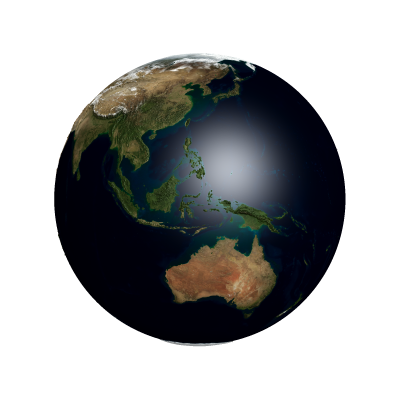

In [3]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(0.0, -125.0, 0.0) #Rotate to Australia
lv.display((400,400))

## Downloading the Test Image
Below we download and save an image from nasa. Note that you may need to change the file path to point to the correct folder.

In [4]:
baseurl = 'https://wvs.earthdata.nasa.gov/api/v1/snapshot?'
params = {'REQUEST': 'GetSnapshot',
          'LAYERS': 'VIIRS_NOAA20_CorrectedReflectance_TrueColor',
          'CRS': 'EPSG:4326',
          'TIME': '2024-09-25',
          'WRAP': 'DAY',
          'BBOX': '-90,-180,90,180',
          'FORMAT': 'image/jpeg',
          'WIDTH': 8192,
          'HEIGHT': 4096,
          'AUTOSCALE': 'TRUE',
          'ts': int(time.time()*1000)
         }
plist = [f"{p}={params[p]}" for p in params]
url = baseurl + '&'.join(plist)
url

fn = os.path.abspath('worldview_earth_snapshot.jpg')

if not os.path.exists(fn):
    accessvis.download(url, filename=fn)

## Loading an image
Note that this data is 180 degrees off, so we need to roll it around.

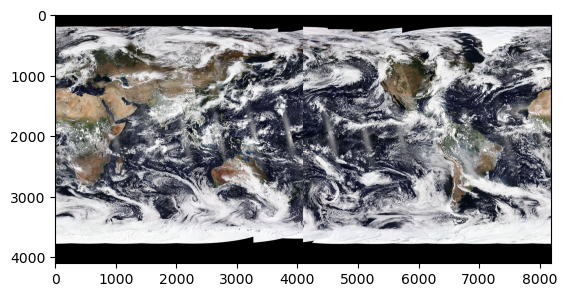

In [5]:
img = Image.open(fn)
arr = np.array(img)
arr = np.roll(arr, arr.shape[1] // 2, axis=1)
plt.imshow(arr)

#### Formatting The Image
We are making the clouds and ice less transparrent so these stand out more.
This is not necessary and is done for aesthetics.

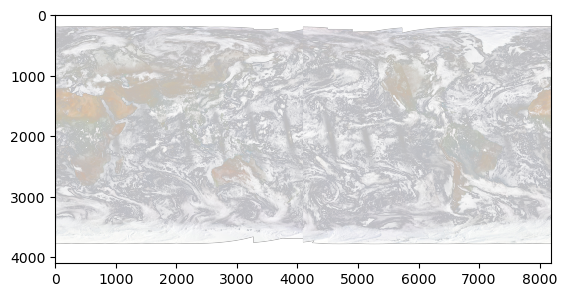

In [6]:
#Use approximate luminance for opacity (so darker = transparent)
#This will reduce the data to mostly clouds and ice areas to overlay over our existing texture
alpha = (0.33*arr[:,:,0] + 0.5*arr[:,:,1] + 0.16*arr[:,:,2]).astype(np.uint8)

#Combine the calculated alpha channel with the rgb data
arr2 = np.dstack((arr, alpha))
plt.imshow(arr2)

# Overlay image data

Note that we are using dataMode=0 so it plots on both land and ocean.


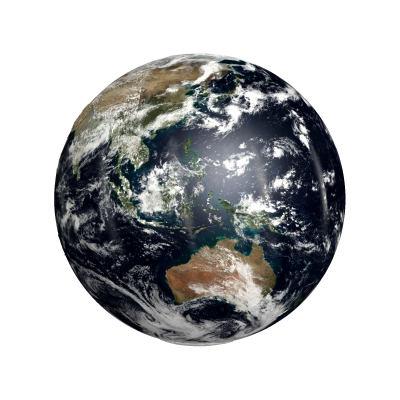

In [7]:
accessvis.update_earth_values(lv, dataMode=0, data=arr2)
lv.display((400,400))

In [8]:
lv.window((600,600))